In [2]:
%load_ext autoreload
%autoreload 2

import timm
from omegaconf import OmegaConf
from ml_utilities.data.datasetgenerator import DatasetGenerator
from tflearning.sample_difficulty import prediction_depth as pdepth
import torch.utils.data as data
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
resnet = timm.create_model('resnet18', pretrained=True)

In [4]:
# create dataset cf10 train split
data_cfg = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
    restrict_n_samples_train_task: 1000
"""
data_cfg = OmegaConf.create(data_cfg)
cf10_ds_gen = DatasetGenerator(**data_cfg.data)
cf10_ds_gen.generate_dataset()
cf10_train = cf10_ds_gen.train_split
cf10_val = cf10_ds_gen.val_split
cf10_trainloader = data.DataLoader(cf10_train, batch_size=128, shuffle=False)
cf10_valloader = data.DataLoader(cf10_val, batch_size=128, shuffle=False)

Files already downloaded and verified


In [5]:
layer_names = pdepth.find_layer_names(resnet, 'act2')
layer_names.append('act1') # add the last layer (activation) of the first block

In [6]:
layer_names

['layer1.0.act2',
 'layer1.1.act2',
 'layer2.0.act2',
 'layer2.1.act2',
 'layer3.0.act2',
 'layer3.1.act2',
 'layer4.0.act2',
 'layer4.1.act2',
 'act1']

In [7]:
pred_depth = pdepth.PredictionDepth(resnet,
                                    layer_names,
                                    train_dataloader=cf10_trainloader,
                                    val_dataloader=cf10_valloader, 
                                    prediction_depth_mode='last_layer_knn_prediction',
                                    append_softmax_output=False)

In [8]:
res = pred_depth.compute()

Computing kNN predictions: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


correct predicted samples: 247
wrong predicted samples: 753
correct predicted samples: 969
wrong predicted samples: 4031


[<Figure size 1417.32x472.441 with 3 Axes>,
 <Figure size 1417.32x472.441 with 3 Axes>]

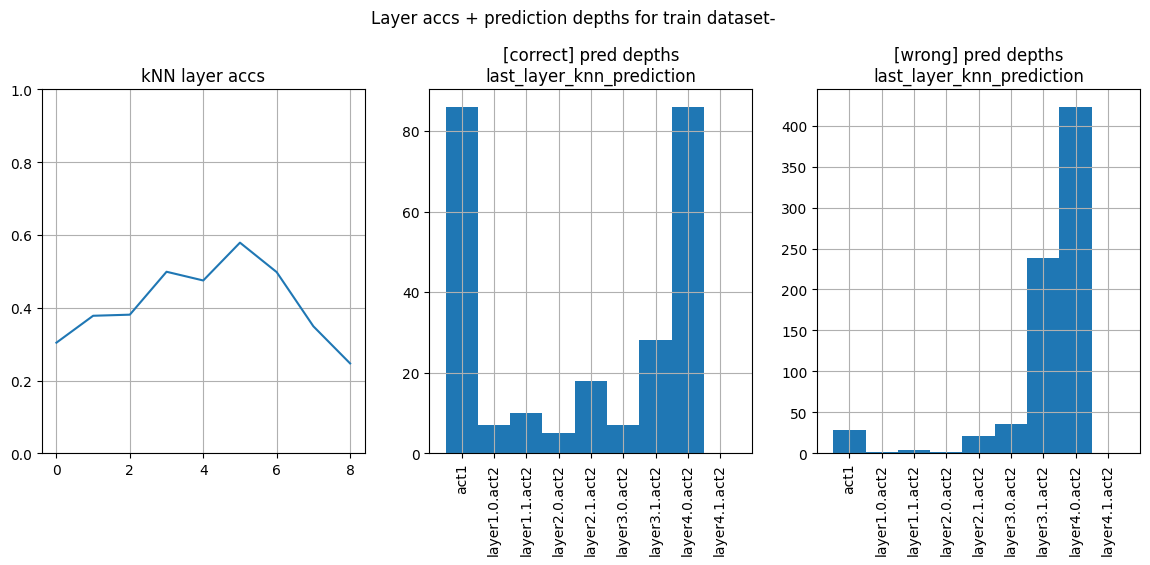

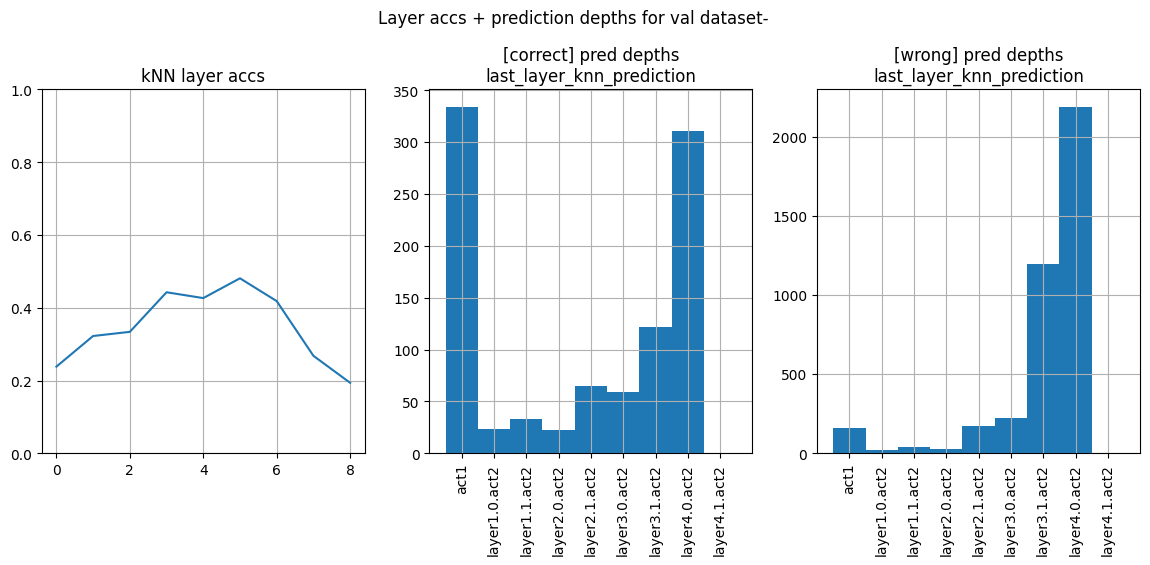

In [15]:
pred_depth._make_plots(res)

In [ ]:
layer_preds = pred_depth.pred_depth_results['train']['layer_preds']

In [ ]:
layer_preds[:5, :]

array([[6, 6, 6, 6, 6, 6, 6, 6, 6],
       [3, 6, 8, 8, 1, 8, 8, 6, 6],
       [2, 6, 6, 6, 6, 7, 7, 7, 7],
       [5, 6, 6, 6, 4, 3, 7, 7, 3],
       [2, 4, 6, 6, 6, 5, 7, 6, 6]])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

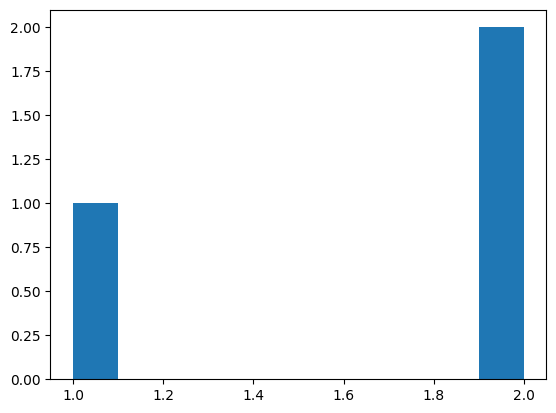

In [11]:
import matplotlib.pyplot as plt
plt.hist(np.array([1,2,2,float('nan')]))